In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
import time
import math
import re
from konlpy.tag import Okt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset


okt = Okt()


warnings.filterwarnings('ignore')

In [2]:
#단어 사전 생성
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class WordVocab():
    def __init__(self):
        SOS_TOKEN = 0
        EOS_TOKEN = 1
        UNKNOWN_TOKEN = 2
        
        self.unknown_token = UNKNOWN_TOKEN
        
        # 각 토큰 별 word count
        self.word2count = {}
        
        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>', 
            UNKNOWN_TOKEN: '<UKN>',
        }
        
        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token
    
    def index_to_word(self, idx):
        return self.index2word[idx]

In [4]:
wordvocab = WordVocab()

In [5]:
#전처리 프로세스를 클레스화 - 데이터 로드, 전처리, 사전 생성, 시퀀스 변환
class QADataset():
    def __init__(self, csv_path, min_length=1, max_length=647):
        data_dir = 'data'
        
        # TOKEN 정의
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰
        
        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정
        
        # CSV 데이터 로드
        df = pd.read_csv(csv_path)
        
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for _, row in df.iterrows():
            src = row['value']
            tgt = row['label']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)            
        
        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab
        

    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(str(sentence))
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences
    
    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)

    
    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        
        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        
        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)
    
    def __len__(self):
        return len(self.srcs)

In [6]:
MAX_LENGTH = 358

dataset = QADataset('./reduce_df.csv', min_length=1, max_length=MAX_LENGTH)

Encoder

In [7]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_len, device):
        """
        sin, cos encoding 구현
        
        parameter
        - d_model : model의 차원
        - max_len : 최대 seaquence 길이
        - device : cuda or cpu
        """
        
        super(PositionalEncoding, self).__init__() # nn.Module 초기화
        
        # input matrix(자연어 처리에선 임베딩 벡터)와 같은 size의 tensor 생성
        # 즉, (max_len, d_model) size
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False # 인코딩의 그래디언트는 필요 없다. 
        
        # 위치 indexing용 벡터
        # pos는 max_len의 index를 의미한다.
        pos = torch.arange(0, max_len, device =device)
        # 1D : (max_len, ) size -> 2D : (max_len, 1) size -> word의 위치를 반영하기 위해
        
        pos = pos.float().unsqueeze(dim=1) # int64 -> float32 (없어도 되긴 함)
        
        # i는 d_model의 index를 의미한다. _2i : (d_model, ) size
        # 즉, embedding size가 512일 때, i = [0,512]
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        
        # (max_len, 1) / (d_model/2 ) -> (max_len, d_model/2)
        self.encoding[:, ::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        
        
    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        # batch_size = 128, seq_len = 30
        batch_size, seq_len = x.size() 
        
        # [seq_len = 30, d_model = 512]
        # [128, 30, 512]의 size를 가지는 token embedding에 더해질 것이다. 
        # 
        return self.encoding[:seq_len, :]

In [8]:
class PositionalEncoding_de(nn.Module):
    
    def __init__(self, d_model, max_len, device):
        """
        sin, cos encoding 구현
        
        parameter
        - d_model : model의 차원
        - max_len : 최대 seaquence 길이
        - device : cuda or cpu
        """
        
        super(PositionalEncoding_de, self).__init__() # nn.Module 초기화
        
        # input matrix(자연어 처리에선 임베딩 벡터)와 같은 size의 tensor 생성
        # 즉, (max_len, d_model) size
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False # 인코딩의 그래디언트는 필요 없다. 
        
        # 위치 indexing용 벡터
        # pos는 max_len의 index를 의미한다.
        pos = torch.arange(0, max_len, device =device)
        # 1D : (max_len, ) size -> 2D : (max_len, 1) size -> word의 위치를 반영하기 위해
        
        pos = pos.float().unsqueeze(dim=1) # int64 -> float32 (없어도 되긴 함)
        
        # i는 d_model의 index를 의미한다. _2i : (d_model, ) size
        # 즉, embedding size가 512일 때, i = [0,512]
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        
        # (max_len, 1) / (d_model/2 ) -> (max_len, d_model/2)
        self.encoding[:, ::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        
        
    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        # batch_size = 128, seq_len = 30
        batch_size, seq_len , d_model= x.size() 
        
        # [seq_len = 30, d_model = 512]
        # [128, 30, 512]의 size를 가지는 token embedding에 더해질 것이다. 
        # 
        return x + self.encoding[:seq_len, :]

In [9]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.pos_encoder = PositionalEncoding(embedding_dim, MAX_LENGTH, device)
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(embedding_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
       
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=True, 
                          batch_first=True,
                          dropout=0.2,
                         )
    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.transformer_encoder.weight.data)
        torch.nn.init.xavier_uniform_(self.gru.weight.data)
        
    def forward(self, x, hidden):

        # (sequence_length, 1)
        x = self.embedding(x)

        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        output, hidden = self.gru(x, hidden)
        return output, hidden
    
    def init_hidden(self, device):
        return torch.zeros(6, self.hidden_size, device=device)

Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.2, max_length=MAX_LENGTH):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.pos_encoder = PositionalEncoding_de(embedding_dim, MAX_LENGTH, device)
        self.decoder_layer = nn.TransformerDecoderLayer(embedding_dim, nhead=8)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim, max_length)
#         self.attn_combine = nn.Linear(hidden_size*3, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embedding_dim,
                          hidden_size,
                          num_layers=1,
                          batch_first=True,
                          dropout=dropout_p)
        self.out = nn.Linear(hidden_size, num_vocabs)

    def init_weights(self):
        for i in range(self.gru.num_layers):
            torch.nn.init.xavier_uniform_(getattr(self.gru, f'weight_hh_l{i}'))
            torch.nn.init.xavier_uniform_(getattr(self.gru, f'weight_ih_l{i}'))

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x).view(1, 1, -1)

        x = embedded
        x = self.pos_encoder(x)
        

        # Using last layer of GRU for attention mechanism
        hidden_last_layer = hidden[-1].unsqueeze(0)
        
#         print(embedded.shape, hidden_last_layer.shape)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden_last_layer), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        encoder_output = attn_applied
#         output = self.attn_combine(output).unsqueeze(0)

   
        output = self.transformer_decoder(x, encoder_output)
        output = F.relu(output)
        hidden = hidden[0].unsqueeze(0)
        output, hidden = self.gru(output[0], hidden)
        output = F.log_softmax(self.out(output), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(5, 1, self.hidden_size, device=device)

Training

In [11]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [12]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()
    
# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [13]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    
    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)
    

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
#     print(encoder_outputs.shape) ## (647,512)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
#         print(encoder_output.shape) ## (1,1,2*512)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
 
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
  
    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden
  
    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
   
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        
        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di])

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    encoder.train()
    decoder.train()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate, betas=(0.9,0.98))
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, betas=(0.9,0.98))
    
    encoder_scheduler = optim.lr_scheduler.StepLR(optimizer=encoder_optimizer,
                                            step_size=10.0,
                                            gamma=0.95,
                                            verbose=False)
    decoder_scheduler = optim.lr_scheduler.StepLR(optimizer=decoder_optimizer,
                                                 step_size=10.0,
                                                 gamma=0.95,
                                                 verbose=False)
    
    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]
    
    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]        
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion, device)
        encoder_scheduler.step()
        decoder_scheduler.step()
        
        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력, 모델 저장
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                }, "./model/Text2Text-se2se2.pt")

            
        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        

    showPlot(plot_losses)

In [15]:
# Hyper-Parameter 정의
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 256
EMBEDDING_DIM = 256
DROPOUT_P = 0.3
NUM_LAYERS = 3

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=NUM_LAYERS)

# Attention 이 적용된 Decoder 정의
decoder = Decoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=MAX_LENGTH)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

1m 31s (remaining: 13m 39s) iter: 100 (10.0%), loss: 4.8945
3m 8s (remaining: 12m 34s) iter: 200 (20.0%), loss: 5.0629
4m 51s (remaining: 11m 20s) iter: 300 (30.0%), loss: 4.6033
6m 32s (remaining: 9m 48s) iter: 400 (40.0%), loss: 4.9106
8m 30s (remaining: 8m 30s) iter: 500 (50.0%), loss: 5.0921
10m 9s (remaining: 6m 46s) iter: 600 (60.0%), loss: 4.7943
11m 43s (remaining: 5m 1s) iter: 700 (70.0%), loss: 4.1507
13m 12s (remaining: 3m 18s) iter: 800 (80.0%), loss: 4.8495
14m 37s (remaining: 1m 37s) iter: 900 (90.0%), loss: 4.3674
16m 11s (remaining: 0m 0s) iter: 1000 (100.0%), loss: 4.7280


<Figure size 640x480 with 0 Axes>

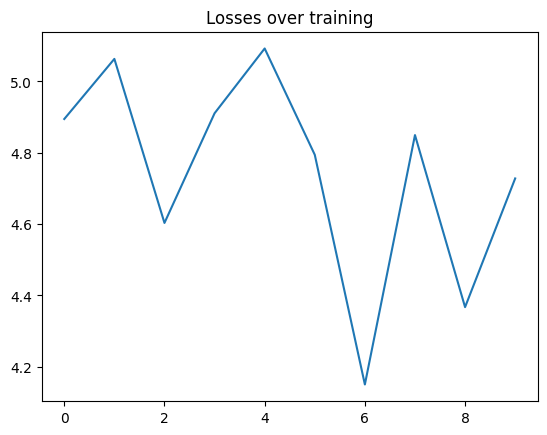

In [73]:
train_iterations(encoder, decoder, 1000, dataset, device, print_every=100)

Evaluation

In [62]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)

        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)
  

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
 
        
        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)
  
        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden
    

        decoded_words = []
      
        decoder_attentions = torch.zeros(max_length, max_length)
      
        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data
            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)
            
            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    

In [63]:
def eval_seq(input_seq, dataset,max_length = MAX_LENGTH):
    
    okt = Okt()
    
    SOS_TOKEN = 0
    EOS_TOKEN = 1
    
    korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
    normalizer = re.compile(korean_pattern)
    
    src = input_seq
    src = normalizer.sub("", str(src))
    src = okt.morphs(src)
    
    sequences = [dataset.wordvocab.word_to_index(w) for w in src]
    # 문장 최대 길이 -1 까지 슬라이싱
    sequences = sequences[:max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
    sequences.append(EOS_TOKEN)
    
    return torch.tensor(sequences).view(-1, 1)

In [64]:
def text_generate(input_seq,encoder, decoder, dataset, device):
    src = input_seq
    a = eval_seq(src,dataset)
    output_words, attentions = evaluate(encoder, decoder, a.to(device), dataset, device)
    output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
    print(output_sentence)

In [65]:
text_generate("싶어",encoder, decoder, dataset, device)

저 는 는 는 는 는 는 는 <EOS>


attention 가중치 시각화

In [66]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy()[:20,:20], cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') , rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

In [67]:
test_seq = eval_seq("반려동물을 키우기 위한 조건 세가지가 있다면 어떤 것이 있다고 생각합니까",dataset)

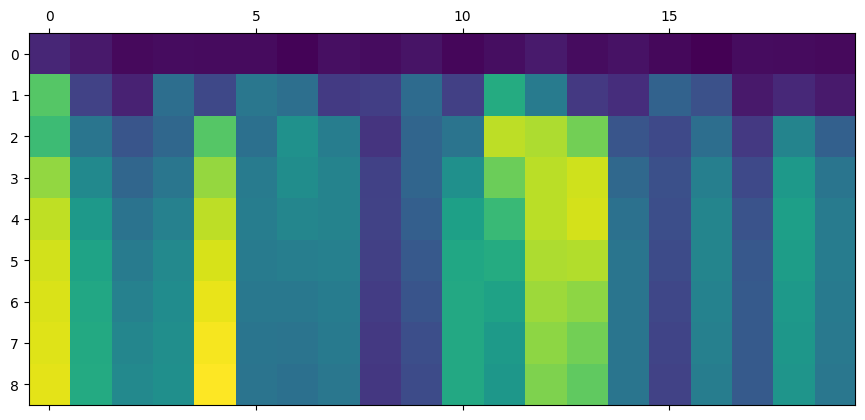

In [68]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, test_seq.to(device), dataset, device)
# plt.figure(figsize=(1000,1000))
plt.matshow(attentions.numpy()[:20,:20])

plt.show()

input = 반려동물 을 키우기 위 한 조건 세 가지 가 있다면 어떤 것 이 있다고 생각 합 니까 <EOS>
output = 저 는 는 는 는 는 는 는 <EOS>


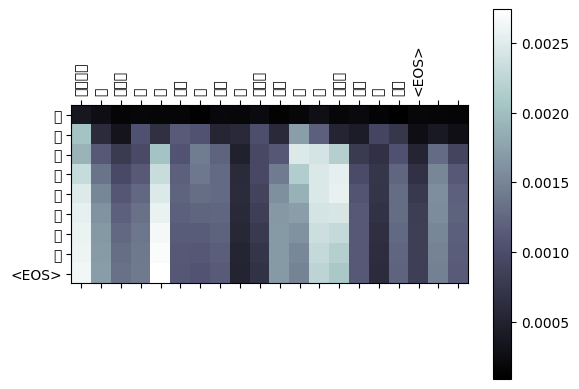

In [69]:
evaluate_and_show_attention(encoder, decoder,test_seq, dataset, device)

In [74]:
from evaluate import load
bertscore = load("bertscore")
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"]
results = bertscore.compute(predictions=predictions, references=references, lang="en")

ModuleNotFoundError: No module named 'evaluate'

In [75]:
def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
        print('<', output_sentence)
        print('')

In [78]:
evaluate_randomly(encoder, decoder, dataset, device)

> 너 는 혹시 시리즈 로 된 영화 본 적 있어 <EOS>
= 해리포터 나 반지 의 제왕 같은 영화 <EOS>
< 저 는 는 는 <EOS>

> 혹시 해보고 싶은 일 있으세요 <EOS>
= 제 가 음식점 에 대해 서 안 좋 은 생각 이 있어서 음식점 한번 안 좋은 생각 없애려고 한번 해보고 싶어요 <EOS>
< 저 는 는 는 <EOS>

> 네 혹시 같이해 볼 생각 이 없냐 <EOS>
= 하게 돼서 네 이렇게 이런 자리 에 오게 되었습니다 <EOS>
< 저 는 는 는 <EOS>

> 플로리다 에 있는 디즈니월드 였나 <EOS>
= 디즈니월드 에 갔는데 진짜 계획 이 보통 한 세 시간 단위 섹션 으로 돼 있어가지고 어 뭐 첫 번째 시간 에는 매직 킹덤 을 가고 어디 뭐 두 번째 시간 에 뭐 다른 먹을 먹는 데 를 가고 뭐 그런 게 계획 이 다 짜져 있어가지고 그 안 그 테마 파크 에서 계속 움직이는 게 다 정해져 있어 가지 고 솔직히 나 는 힘들었던 게 내 체력 은 그만큼 안 받아주는데 되게 그만큼 더 움직여야 되는 거고 친구 들 있으니까 움직여야 되는 거 잖아 <EOS>
< 저 는 는 는 <EOS>

> 이런 음 컬래버 도 되게 많이 하는 것 같은데 혹시 어 옛날 가수 랑 지금 가수 랑 컬래버 해서 아니면 리메이크 해서 어 부른 노래 중 에 좋아하는 노래 있으세요 <EOS>
= 음 딱히 막 최애 다 이런 건 없고 생각나는 건 아이유 랑 뭔 송원 창 ? <EOS>
< 저 는 는 는 <EOS>

> 한 10 첩 반상 나와 <EOS>
= 10 첩 반상 이 아니고 가정 집 에서 나오듯이 매일 메뉴 가 바뀌는 거 같아 <EOS>
< 저 는 는 는 <EOS>

> 어 name 2 씨 는 뭐 보고 싶은 드라마 있으신 가요 <EOS>
= 어 저 도 말씀 하신 사이코 지만 괜찮아 사실 은 보고 싶어 하고 있고요 <EOS>
< 저 는 는 는 <EOS>

> name 1 님 은 어떠신 가요 <EOS>
= 저 도 학교 학창 시절 부터 연예인 이 이상형 이 거나 뭐 그런 적은 없 그